<hr style="border-width:4px; border-style:solid; border-color:coral"/>

# Assimilating data into the advection equation using the representer method.
<hr style="border-width:4px; border-style:solid; border-color:coral"/>


The notebook solves the scalar advection equation, given by the partial differential equation

\begin{equation}
q_t + u q_x = Q(x,t)
\end{equation}

with the  initial and boundary conditions as below;

\begin{align}
    {q}(x,0)&= 0 ~~~~~~~~~ x\in [a,b]\\
    {q}(0,t)&= B(t) ~~~~ t\in[0,T_{final}]
\end{align}

where $u$ is a prescribed velocity field.  This equation models, for example, the transport of a tracer field in a background flow.  

We solve this problem in the periodic domain $x \in [32,42]$ over the time interval $t \in [0,T_{final}]$.  We set the velocity field to $u=1$. 

Observed data values are assimilated into the calculation to improve the model to more accurately predict the observed values.

In this notebook, we use the numerical integration.  

In [1]:
from numpy import *
from matplotlib.pyplot import *
import seedbank
import scipy
from scipy.interpolate import PPoly
import scipy.stats
from scipy.special import erf
from scipy.integrate import dblquad
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize, fsolve,fmin, least_squares
import contextlib
import warnings
warnings.filterwarnings('ignore')

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Initial condition 

In [2]:
def initial_condition(x):
    return zeros(len(x))

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Forcing

$Q = S_1 \exp(-k_1t - \alpha _1 r^2) + S_2 \exp(-k_2 t - \alpha _2 r^2)$



In [3]:
def forcing(x, t, N, M, x1, S1, k1, alpha1, x2, S2, k2, alpha2):
    r1 = abs(x - x1)
    r2 = abs(x - x2)
    Q = zeros((N+1, M+1))
    for m in range(0, M+1):
        tau = t[m]
        Q[:, m] = S1 * exp(-k1 * tau - alpha1 * r1**2) + S2 * exp(-k2 * tau - alpha2 * r2**2)
    return Q

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Upwind scheme

When the velocity $u>0$
   \begin{align}
        q_n^{m+1} &= q_n^{m} - \frac{u\Delta t}{\Delta x}\big(q_{n}^m - q_{n-1}^m\big)+ Q_n^m \\
        q_n^0 &= 0\\
        q_0^m &= q_N^m
     \end{align}
        
  When $u<0$
  
  \begin{align}
        q_n^{m+1} &= q_n^{m} - \frac{u\Delta t}{\Delta x}\big(q_{n+1}^m - q_{n}^m\big)+ Q_n^m \\
        q_n^0 &= 0\\
        q_N^m &= q_0^m
     \end{align}

In [4]:
def upwind(x, t, dx, dt, N, M, u, q0,  Q):
    qF = zeros((N + 1, M + 1))
    qF[:, 0] = q0
    for m in range(1, M + 1):
        if u > 0:
            for n in range(1, N + 1):
                qF[n, m] = qF[n, m - 1] - (u * dt / dx) * (qF[n, m - 1] - qF[n - 1, m - 1]) + dt * Q[n, m]
            qF[0, m] = qF[N, m] 
        else:
            for n in range(0, N):
                qF[n, m] = qF[n, m - 1] - (u * dt / dx) * (qF[n + 1, m - 1] - qF[n, m - 1]) + dt * Q[n, m]
            qF[N, m] = qF[0, m]  

    return qF

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

### Interpolation (getting the representer matrix $r_l (x_m,t_m)$)

We may find that some $t_m \not\in t$ and $x_m \not\in x$. In such cases we interpolate $t_m$ and $x_m$ positions  in order to obtain $r_l (x_m,t_m)$ from the representer numerical solution $R_m$. 

In [5]:
def rl(H,xm,tm):
    idx = where(x == xm)[0][0]
    idt = where(t == tm)[0][0]
    
    qvec_x = H[idx,:]
    qvec_t = H[:,idt]
    q_val = H[idx,idt]
    return q_val, qvec_x, qvec_t

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## RMSE

In [6]:
def RMSE(q, qhat):
    mse = mean_squared_error(q.flatten(), qhat.flatten())
    rmse = sqrt(mse)
    return rmse

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Simulated data

We create obseverable data triples (xm,tm,dm) using a random number generator. The data values are taken to be perturbations to an exactly defined solution for the unforced scalar advection problem.

In [7]:
def select_xm_tm(x,t,N,M,num_xm, num_tm):
    
    loc_step = N // (num_xm - 1) if num_xm > 1 else 0
    time_step = M // (num_tm - 1) if num_tm > 1 else 0

    xm = x[3::loc_step+3] if loc_step > 0 else x
    tm = t[3::time_step+3] if time_step > 0 else t
    
    
    xm_mesh, tm_mesh = meshgrid(xm, tm)

    xm_data = xm_mesh.ravel()
    tm_data = tm_mesh.ravel()
    mdata = len(xm_data)
    
    return xm_data, tm_data, mdata

In [8]:
def qm(x, t, q, xm_data, tm_data, mdata):
    qm_data = np.zeros(mdata)
    for j in range(0,mdata):
        qm = rl(q,xm_data[j],tm_data[j])[0]
        qm_data[j] = qm
    return qm_data

In [9]:
def simulated_data(qm_data, sigma, xm_data, tm_data, mdata):
    n = 10000
    dm_data = empty(mdata)
    errors_MC = empty((mdata,n))    
    for i in range(n):
        noise_std = sigma * qm_data
        noise = random.normal(loc=0.0, scale=noise_std, size=qm_data.shape)

        dm_data = qm_data + noise
        dm_data = clip(dm_data, a_min=0, a_max=None)

        errors_MC[:,i] = dm_data - qm_data
    std_row = std(errors_MC, axis=1)    
    
    sigma_m = std_row
    
    return dm_data, sigma_m

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

# User defined Parameters

In [10]:
'''SPATIAL AND TEMPORAL MESHES'''
u = 1                            # Constant velocity
CFL = 0.6                        # CFL number,0 < CFL < 1. 

a = 30                           # Domain limit to the left
b = 45                           # Domain limit to the right

T  = 20                           # Final time
t0 = 0                            # initial time

N = 50                         # Number of cells in space


# Spatial mesh
dx = (b-a)/N                      # Mesh cell size 
x = linspace(a,b,N+1)             # Discretized spatial mesh 

# Temporal mesh
dt_est = CFL*dx/u                 # This ensures that the CFL condition is met
M= int(T/dt_est)+1                # Time step
dt = T/M                          # Number of iterations
t = linspace(0,T,M+1) 

In [11]:
'''TRUE SOLUTION'''
alpha1 = 5
S1 = 100
k1 = 0.5
x1 = 33

alpha2 = 0
S2 = 0
k2 = 0
x2 = 0

q0 = initial_condition(x)#
Q = forcing(x, t, N, M, x1, S1, k1, alpha1, x2, S2, k2, alpha2)
q = upwind(x, t, dx, dt, N, M, u, q0,  Q)

In [12]:
'''PRIOR ESTIMATES'''
def first_guess(x, t, dx, dt, N, M, u, q0, x1, S1, k1, alpha1, x2, S2, k2, alpha2, sigma_k1, sigma_alpha1, sigma_k2, sigma_alpha2):
    np.random.seed(500)
    

    k1_F = k1 + sigma_k1 * np.random.randn()  
    alpha1_F = alpha1 + sigma_alpha1 * np.random.randn()
    
    k2_F = k2 + sigma_k2 * np.random.randn()  
    alpha2_F = alpha2 + sigma_alpha2 * np.random.randn()

    QF = forcing(x, t, N, M, x1, S1, k1_F, alpha1_F, x2, S2, k2_F, alpha2_F)
    qF = upwind(x, t, dx, dt, N, M, u, q0,  QF)
    return qF

sigma_k1, sigma_alpha1 = 0.5, 0.7
sigma_k2, sigma_alpha2 = 0, 0

qF = first_guess(x, t, dx, dt, N, M, u, q0, x1, S1, k1, alpha1, 
                 x2, S2, k2, alpha2, sigma_k1, sigma_alpha1, sigma_k2, sigma_alpha2)

In [13]:
sigma = 0.3
num_xm, num_tm = 8, 8

xm_data, tm_data, mdata = select_xm_tm(x, t, N, M, num_xm, num_tm)
qm_data = qm(x, t, q, xm_data, tm_data, mdata)

data_expt3 = np.loadtxt("data_expt3_50.csv", delimiter=",")
sigma_expt3 = np.loadtxt("sigma_expt3_50.csv", delimiter=",")


dm_data, sigma_m = data_expt3[:, 4],sigma_expt3[:, 4]
data = list(zip(xm_data, tm_data, dm_data, sigma_m **2))

In [14]:
print(f"The RMSE between the true solution and obsservational data is: {RMSE(qm_data, dm_data)}\n")
print(f"The RMSE between the true solution and prior estimates is: {RMSE(q, qF)}\n")

The RMSE between the true solution and obsservational data is: 3.186293417429414

The RMSE between the true solution and prior estimates is: 6.310340916315657



<hr style="border-width:4px; border-style:solid; border-color:coral"/>

### Solving for the adjoint $\alpha_m (x,t)$

The adjoints $\alpha_m (x,t)$ are solved numerically backward in time and space as;     \begin{align}
        (\alpha_m)_i^{n} &= (\alpha_m)_i^{n+1} + \frac{u\Delta t}{\Delta x}\big((\alpha_m)_{i+1}^{n+1} - (\alpha_m)_i^{n+1}\big) + \Delta t F_i^n \\
        (\alpha_m)_i^T &= 0\\
        (\alpha_m)_1^n &= 0
        \end{align}
        
where $(\alpha_m)_i^{n} = \alpha_m (x_i,t_n)$, $(\alpha_m)_i^{n+1} = \alpha_m(x_i,t_{n+1})$, $(\alpha_m)_{i+1}^{n+1} = \alpha_m(x_{i+1},t_{n+1})$ and $F_i^n = \delta(x_i-x_{m})\delta(t_n-t_{m}) $

In [15]:
# Sharpness of the delta function 
eps = 1e-3                                  

# Delta function
def delta(x):                  
    return exp(-x**2/(4*eps))/sqrt(4*pi*eps)


def adjoint(x,t,dx,dt,u,N,M,xm,tm):
    q0 = zeros(N+1)
    Q = zeros((N+1,M+1))
    for m in range(0,M+1):
        tau = t[m]
        Q[:,m] = delta(x-xm)*delta(T-tm-tau)
    alpha_m = upwind(x, t, dx, dt, N, M, -u, q0,  Q) 
       
    adjoint = zeros((N+1,M+1))
    for m in range(0,M+1):
        adjoint[:,m] = alpha_m[:,M-m]
            
    return adjoint

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## Model Error Covariance $C_f$

### Behavior of the Covariance Function as  $l_f$, $\tau_f$ Vary

The covariance function is given by:
\begin{equation}
C_f(x, t, x', t') = \sigma_f^2 \exp \left( - \left( \frac{|x - x'|^2}{l_f^2} + \frac{|t - t'|}{\tau_f} \right) \right).
\end{equation}

#### Case 1:

As $l_f$, $\tau_f \to 0 $ , the terms $ \frac{|x - x'|^2}{l_f^2} $, $ \frac{|t - t'|}{\tau_f} \to \infty $ 

\begin{equation}
\lim_{l_f, \tau_f \to 0} C_f(x, t, x', t') = \sigma_f^2 \exp \left( - \infty \right) = 0.
\end{equation}

When $l_f$, $\tau_f$ are very small, the covariance between different points decays quickly.


#### Case 2: 

As $l_f$, $\tau_f \to \infty $, the terms $ \frac{|x - x'|^2}{l_f^2} $, $ \frac{|t - t'|}{\tau_f^2} \to 0 $

\begin{equation}
\lim_{l_f, \tau_f \to \infty} C_f(x, t, x', t') = \sigma_f^2 \exp (0) = \sigma_f^2.
\end{equation}

This means that for large $l_f$, $\tau_f$, the covariance remains high across all points.

In [16]:
def covariance_function(x, t, sigma_f, l_f, tau_f):
    Nx = len(x)
    Mt = len(t)
    Cf = zeros((Nx * Mt, Nx * Mt))
    for i in range(Nx):
        for j in range(Nx):
            for k in range(Mt):
                for l in range(Mt):
                    spatial_term = ((x[i] - x[j]) / l_f) ** 2
                    temporal_term = (abs(t[k] - t[l]) / tau_f) 
                    Cf[i * Mt + k, j * Mt + l] = sigma_f**2 * exp(- (spatial_term + temporal_term))
    
    return Cf

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

### Solving for the representers $r_m (x,t)$

The adjoints $r_m (x,t)$ are solved numerically forward in time and space as;     \begin{align}
        (r_m)_i^{n+1} &= (r_m)_i^{n} + \frac{u\Delta t}{\Delta x}\big((r_m)_{i}^{n} - (r_m)_{i-1}^{n}\big) + \Delta t C_f {(\alpha_m)}_i^n \\
        (r_m)_i^T &= 0\\
        (r_m)_1^n &= 0
        \end{align}
       

In [17]:
def representers(x, t, dx, dt, u, M, N, alpha, Cf):
    q0 = zeros(N + 1)
    if isscalar(Cf):
        q0 = 0 *alpha[:,0]                         #Ci*alpha[:,0]    # initial condition 
        Q = zeros((N+1,M+1))
        for m in range(1,M+1):
            Q[:,m] = Cf*alpha[:,m] 
        qF = upwind(x, t, dx, dt, N, M, u, q0,  Q)    
    else:
        alpha_vec = alpha.flatten()# Flatten alpha to match Cf shape
        Q_vec = Cf @ alpha_vec       # Apply covariance matrix
        Q = Q_vec.reshape(N + 1, M + 1)    # Reshape result back to match (N+1, M+1)
        qF = upwind(x, t, dx, dt, N, M, u, q0, Q)    
    return qF


<hr style="border-width:4px; border-style:solid; border-color:coral"/>

### Computing the PM$_{2.5}$ concentration estimates

The representers are computed using numerical integration.

In [18]:
def solution(x,t,dx,dt,u,M,N,Cf,qF,mdata,data):
    Rm = zeros((mdata,mdata))
    h = zeros(mdata)
    rmd = []

    for j,d in enumerate(data):
        xm = d[0]
        tm = d[1]
        dm = d[2]
        alpha = adjoint(x,t,dx,dt,u,N,M,xm,tm)
        rm = representers(x,t,dx,dt,u,M,N,alpha,Cf)
        rmd.append(rm)

        # Getting qF(xm,tm) entries
        h[j]   = dm - rl(qF,xm,tm)[0]

        # Computing matrix R
        for i,di in enumerate(data):
             Rm[i,j] = rl(rm,di[0],di[1])[0]

    # Creating matrix of data weights using diagonal weighting
    Cm = [C[3] for C in data]
    w_inv = diag(Cm)

    # Solving for beta values
    P = Rm + w_inv
    beta = linalg.solve(P,h)


    # Getting concetration estimates qhat
    qhat = qF.copy()
    for j,d in enumerate(data):
        qhat += beta[j]*rmd[j]
    
    return qhat,P,h,w_inv,Rm

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

### L-curve

In [19]:
def Residual_norm(P,h,w_inv):  
    residual_norm = (h.T)@linalg.inv(P)@w_inv@linalg.inv(P)@h
    return residual_norm

In [20]:
def Reg_norm(P,h,R,Cf):
    m = (h.T)@linalg.inv(P)@R@linalg.inv(P)@h
    J_mod = Cf* m
    return J_mod

In [21]:
def calc_curvature(x, y):
    # Calculate the first and second derivatives using numerical differentiation
    dx = np.gradient(x)
    dy = np.gradient(y)
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    # Calculate the curvature using the formula:
    # k = |dx dy'' - dy dx''| / ((dx**2 + dy**2)**(3/2))
    numerator = np.abs(dx * d2y - dy * d2x)
    denominator = (dx**2 + dy**2)**(3/2)
    curvature = numerator / (denominator + np.finfo(float).eps)  # Add a small value to avoid division by zero

    return curvature


In [47]:
def l_curve_corner(rho, eta, reg_param):
    # Convert to log-log scale
    x = np.log10(rho)
    y = np.log10(eta)

    # Smooth data
    n = len(x)
    window_length = min(max(5, n // 4 * 2 + 1), 21)  # must be odd
    polyorder = min(3, window_length - 1)
    x_smooth = savgol_filter(x, window_length, polyorder)
    y_smooth = savgol_filter(y, window_length, polyorder)

    # Define triangle points
    x1 = x_smooth[:-2]
    x2 = x_smooth[1:-1]
    x3 = x_smooth[2:]
    y1 = y_smooth[:-2]
    y2 = y_smooth[1:-1]
    y3 = y_smooth[2:]

    # Compute triangle side lengths
    a = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
    b = np.sqrt((x1 - x3)**2 + (y1 - y3)**2)
    c = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

    # Compute semi-perimeter
    s = (a + b + c) / 2

    # Avoid negative/zero values under sqrt
    area_sq = s * (s - a) * (s - b) * (s - c)
    area_sq = np.maximum(area_sq, 1e-20)
    area = np.sqrt(area_sq)

    # Compute circumradius
    R = (a * b * c) / (4.0 * area)

    # Filter out invalid values
    R[np.isnan(R)] = np.inf
    R[np.isinf(R)] = np.inf

    # Curvature (reciprocal of radius)
    curvature = np.zeros(n)
    curvature[1:-1] = 1.0 / R

    # Choose the index of maximum curvature
    ireg_corner = np.argmax(curvature)
    reg_corner = reg_param[ireg_corner]

    return reg_corner, ireg_corner

In [22]:
def L_curve(x,t,dx,dt,u,M,N,mdata,data,sigmas):
    residual_norm = np.zeros(len(sigmas))
    regularization_norm = np.zeros(len(sigmas))
    J = zeros(len(sigmas))

    for i in range (len(sigmas)):
        sigma_f = sigmas[i]
        Cf = sigma_f**2
        
        qhat, P, h, w_inv, R = solution(x,t,dx,dt,u,M,N,Cf,qF,mdata,data)
        
        residual_norm[i] = Residual_norm(P,h,w_inv)    
        regularization_norm[i] =  Reg_norm(P,h,R,Cf) 
        J[i] = (h.T) @ linalg.inv(P) @ h
    
    curvature = calc_curvature(residual_norm, regularization_norm)
    max_curvature_idx = np.argmax(curvature)
    optimal_Lcurve_sigma = sigmas[max_curvature_idx]
        
    return residual_norm, regularization_norm, J, curvature, max_curvature_idx, optimal_Lcurve_sigma


In [23]:
sigmas = logspace(-3,3 , 1000)
res_norm, reg_norm, J, curvature, corner_index, optimal_Lcurve_sigma =  L_curve(x,t,dx,dt,u,M,N,mdata,data,sigmas)

In [48]:
reg_corner, ireg_corner = l_curve_corner(res_norm, reg_norm,sigmas)

In [49]:
curvature = calc_curvature(res_norm,reg_norm)
max_curvature_idx = np.argmax(curvature)
optimal_Lcurve_sigma = sigmas[max_curvature_idx]
corner_index = where(sigmas == optimal_Lcurve_sigma )
print(f"\n Corner Variance: {reg_corner**2:.5f}\n")
print(f"\n Optimal L-curve sigma: {optimal_Lcurve_sigma**2:.5f}\n")


 Corner Variance: 0.37461


 Optimal L-curve sigma: 1.33698



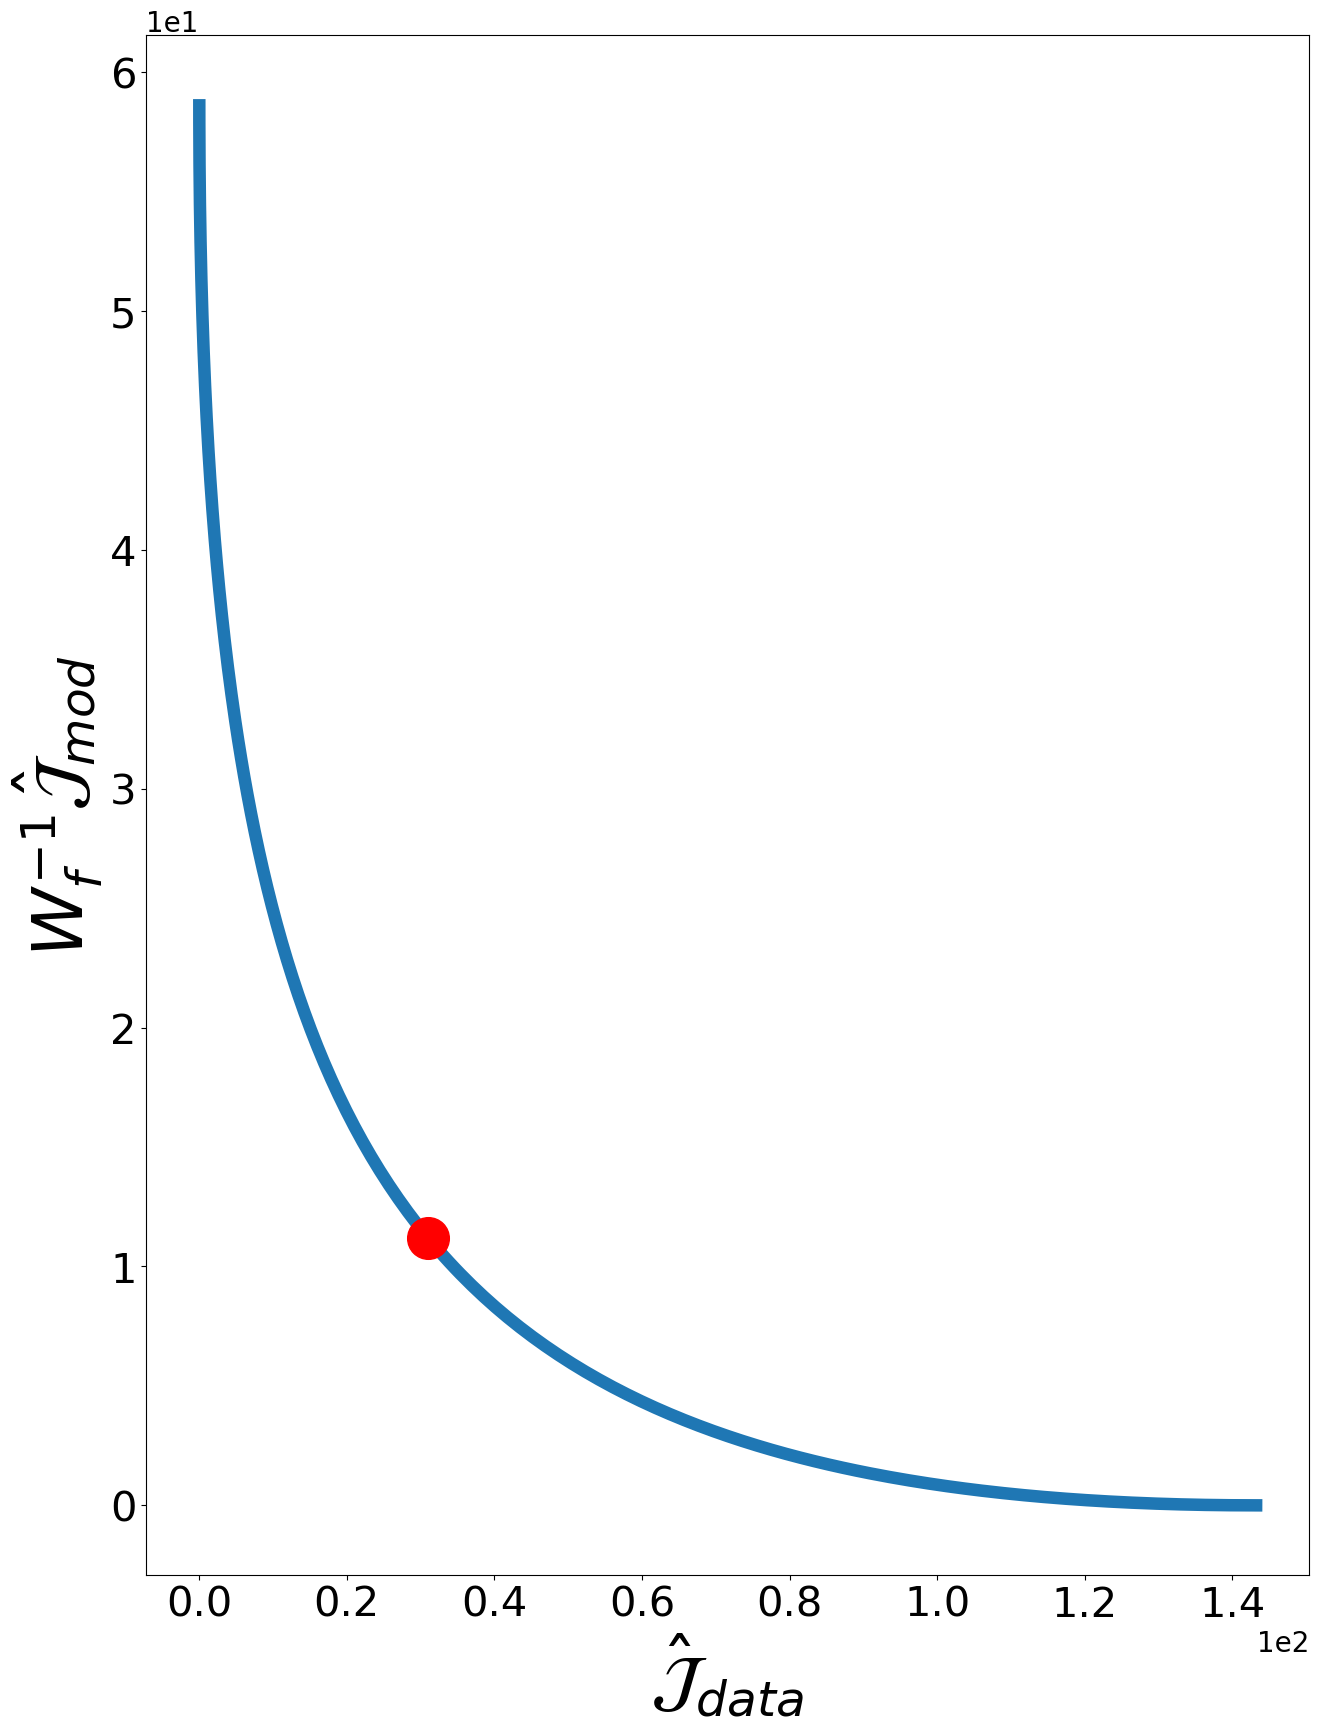

In [51]:
fig = figure(figsize=(15, 20))
plot(res_norm,reg_norm,linewidth=9)
plot(res_norm[ireg_corner],reg_norm[ireg_corner],'ro',markersize=30)
ylabel(r'$W_f^{-1} \hat{\mathcal{J}}_{mod}$', fontsize=50)
xlabel(r'$ \hat{\mathcal{J}}_{{data}}$', fontsize=50)
ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

tick_params(axis='both', labelsize=30)
savefig('lcurve_3.png')
show()


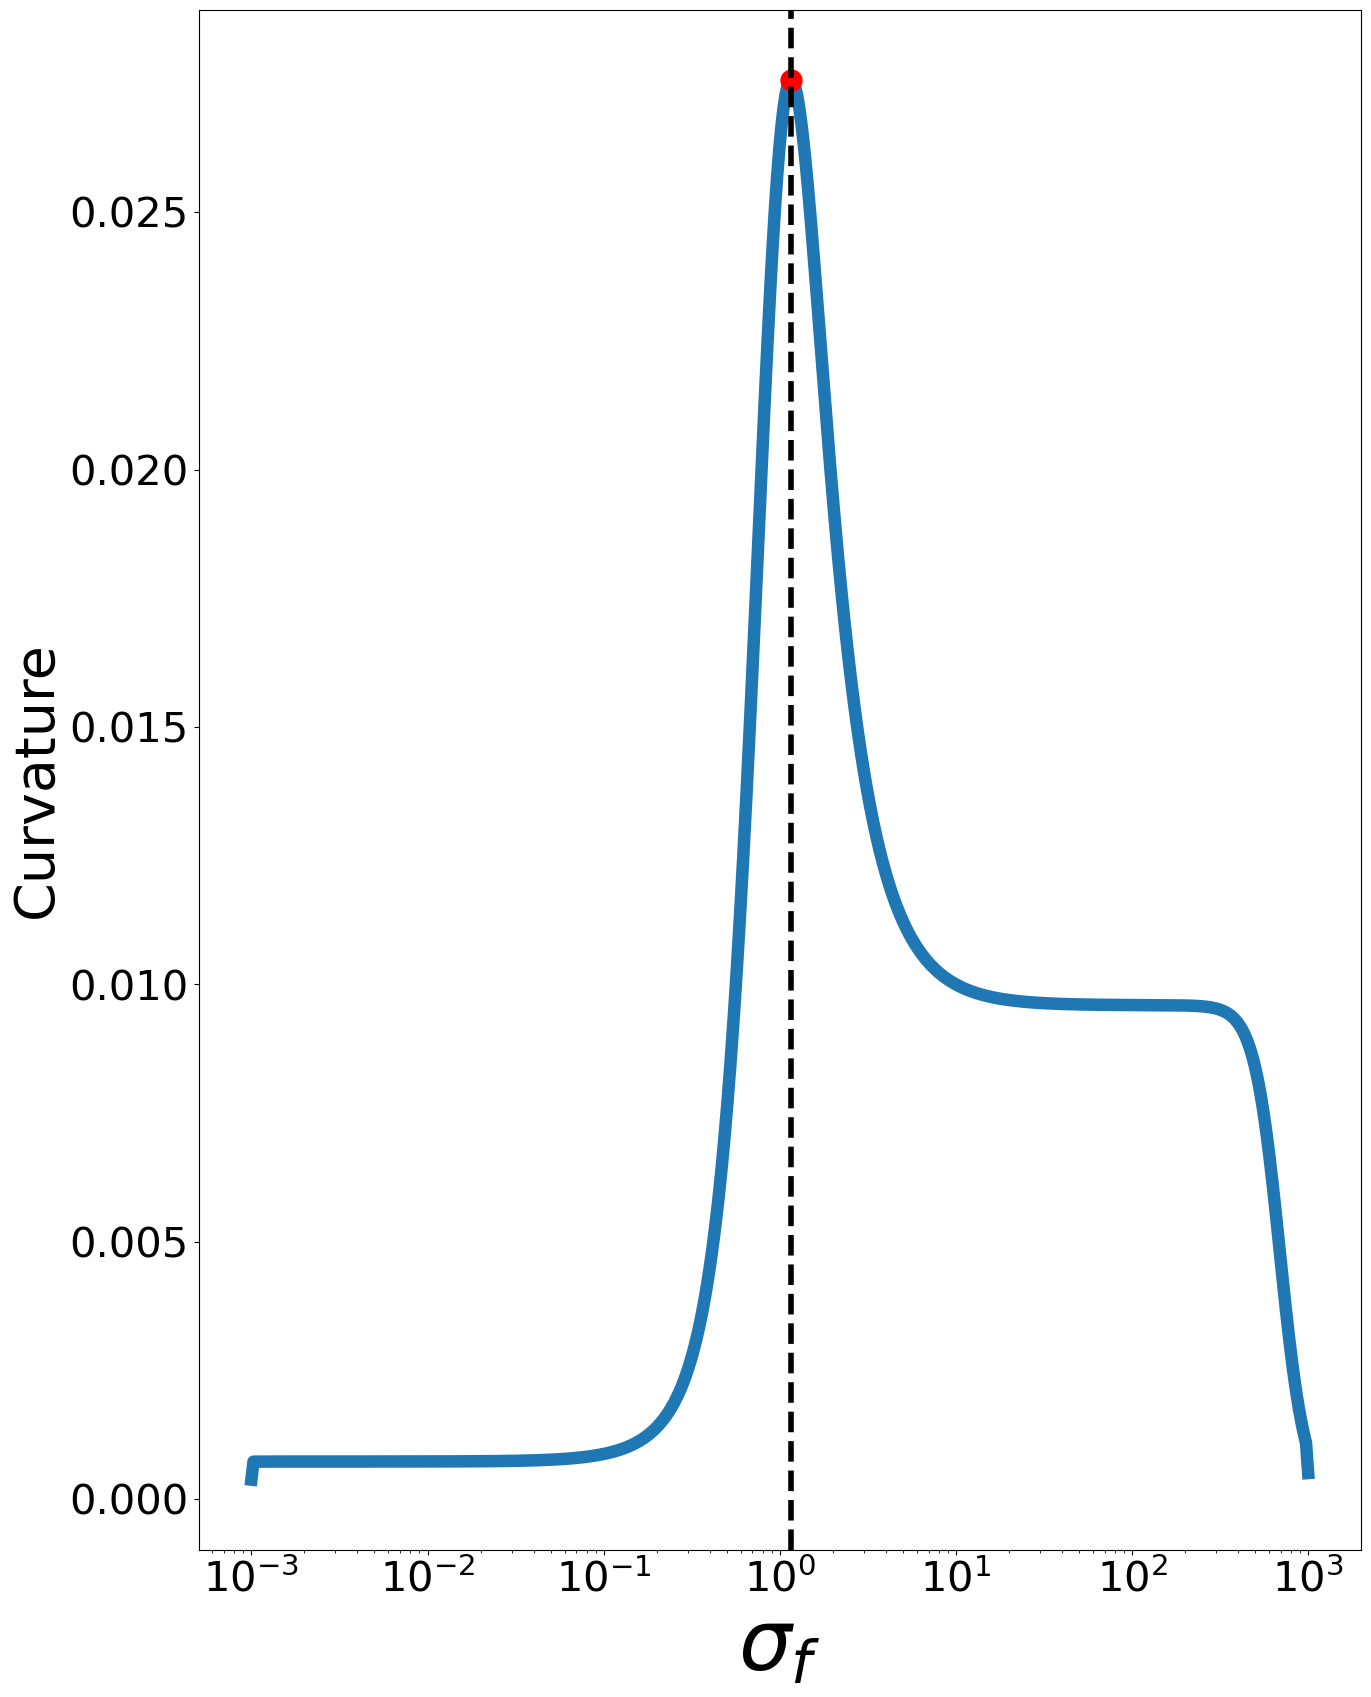

In [46]:
fig = figure(figsize=(15, 20))
semilogx(sigmas, curvature ,linewidth=9)
semilogx(optimal_Lcurve_sigma,curvature[corner_index[0][0]],'ro',markersize=15)
axvline(optimal_Lcurve_sigma, color='k', linestyle='--',linewidth=4, label=f'$\sigma_f ^2$={optimal_Lcurve_sigma**2:.4f}')

ylabel('Curvature', fontsize=40)
xlabel("$\sigma _f$", fontsize=60)
tick_params(axis='both', labelsize=30)
savefig('curvature_4.png')
show()

<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## GCV

In [26]:
def GCV1(x,t,dx,dt,u,M,N,mdata,data,sigmas):
    gcv_scores = zeros(len(sigmas))
    for i in range (len(sigmas)):
        sigma_f = sigmas[i]
        Cf = sigma_f**2
        qhat,P,h,w_inv,Rm = solution(x,t,dx,dt,u,M,N,Cf,qF,mdata,data)
        residual_norm = Residual_norm(P,h,w_inv)  
        R_hash =  Rm@(linalg.inv(P))     
        gcv_scores[i] = (mdata* (residual_norm))/ (trace(eye(mdata)- R_hash))**2
    
    min_index = np.argmin(gcv_scores)  
    optimal_GCV_sigma = sigmas[min_index]
    return gcv_scores, optimal_GCV_sigma,min_index 


In [27]:
gcv_scores, optimal_GCV_sigma,min_index  = GCV1(x,t,dx,dt,u,M,N,mdata,data,sigmas)

In [28]:
print(f"Optimal GCV sigma: {optimal_GCV_sigma**2:.4e}\n")

Optimal GCV sigma: 8.8297e-01



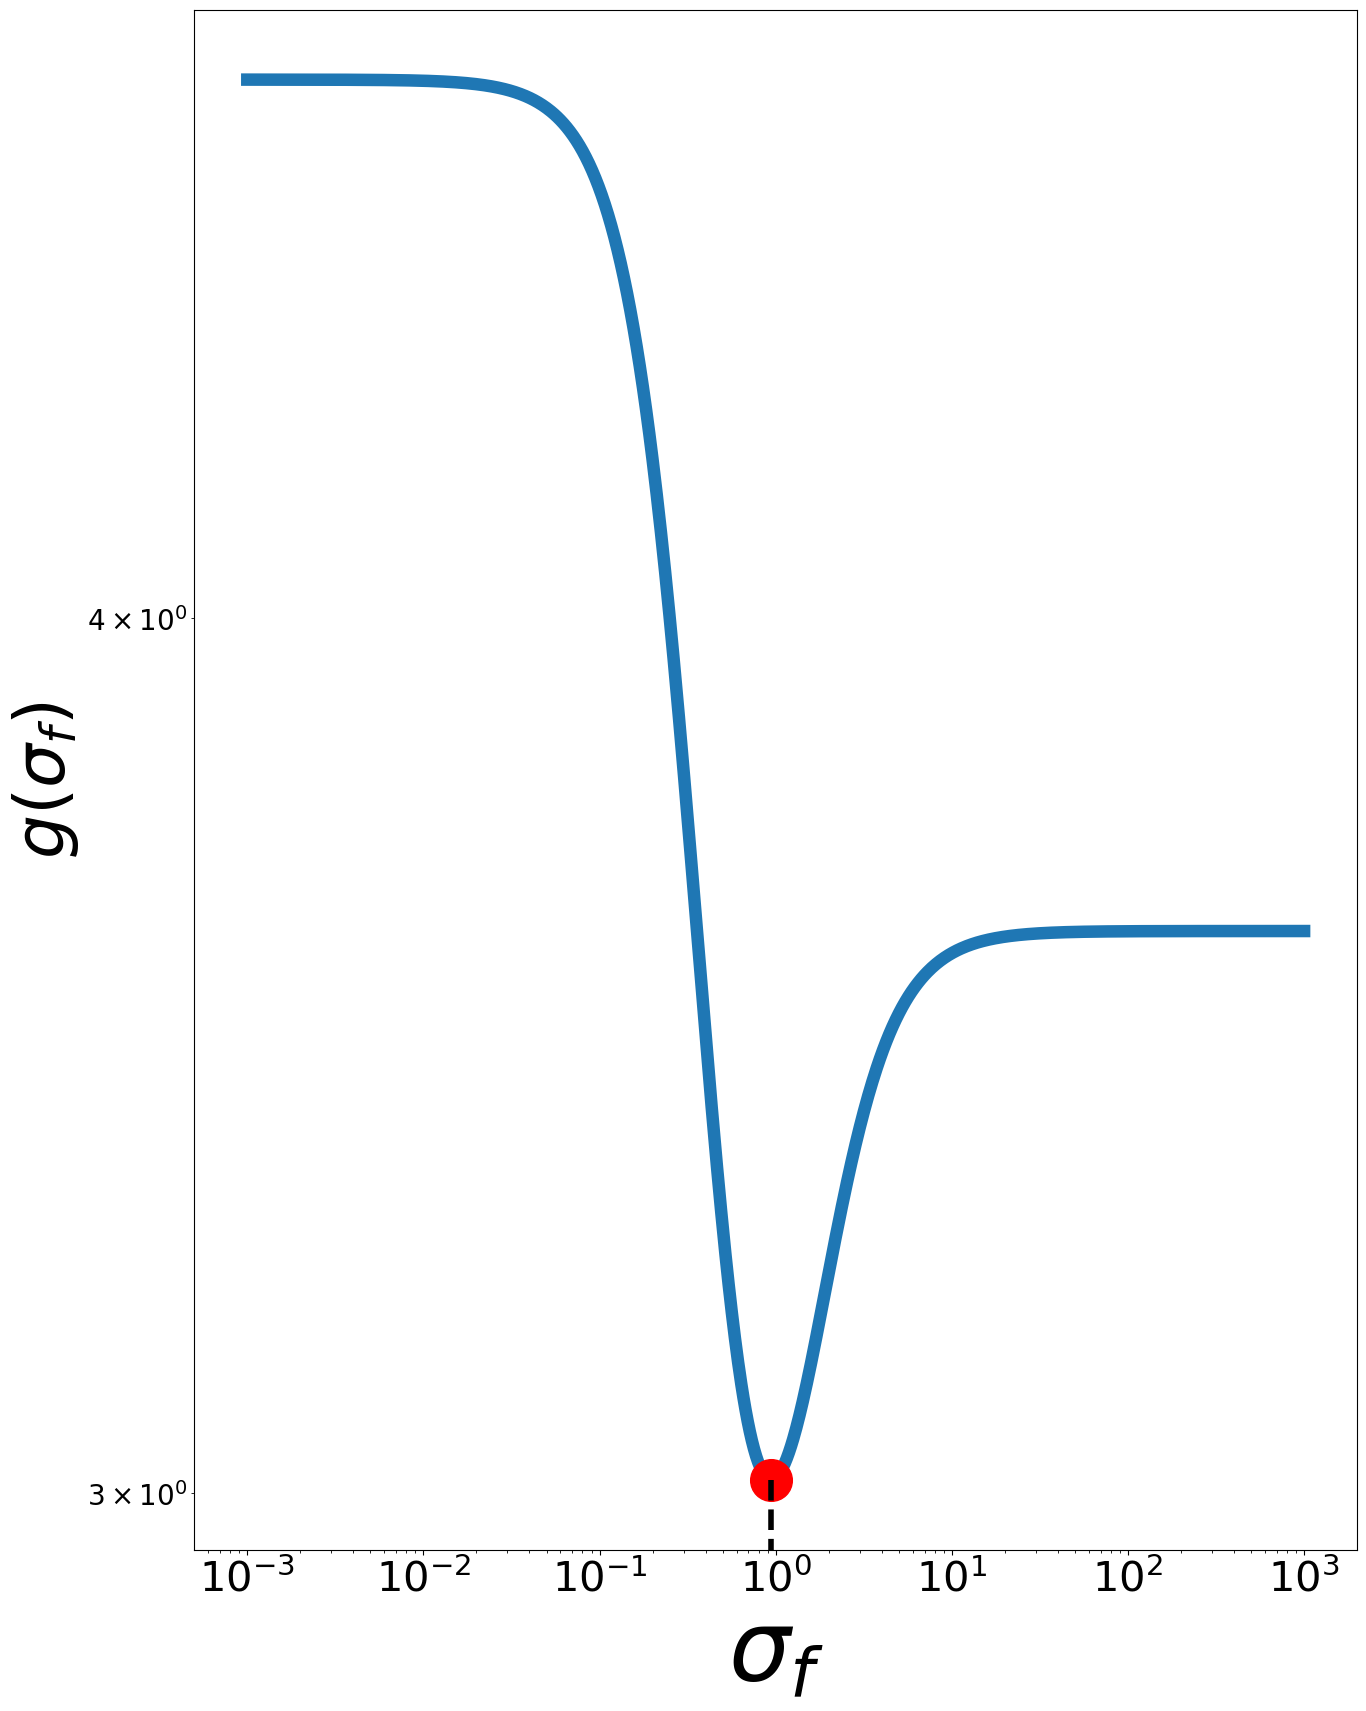

In [52]:
fig = figure(figsize=(15, 20))
loglog(sigmas,gcv_scores,linewidth=9)
loglog(sigmas[min_index],gcv_scores[min_index],'ro',markersize=30)
loglog([sigmas[min_index], sigmas[min_index]], [gcv_scores[min_index], 0], 'k--',linewidth=4)
xlabel(r'$\sigma _f$', fontsize=70)
ylabel(r'$g(\sigma _f)$', fontsize=50)
tick_params(axis='both', labelsize=30)
savefig('gcv_3.png')
show()


<hr style="border-width:4px; border-style:solid; border-color:coral"/>

## $\chi ^2$

In [30]:
def chi1(J,sigmas,mdata):
    difference_array = np.absolute(J - mdata*ones(len(J)))
    index = difference_array.argmin()
    optimal_chi_square_sigma = sigmas[index]
    return optimal_chi_square_sigma,index

In [31]:
optimal_chi_square_sigma,chi_index = chi1(J,sigmas,mdata)

In [32]:
print(f'optimal_Cf_chi_square = {optimal_chi_square_sigma**2:.4e}\n')

optimal_Cf_chi_square = 1.2305e+00



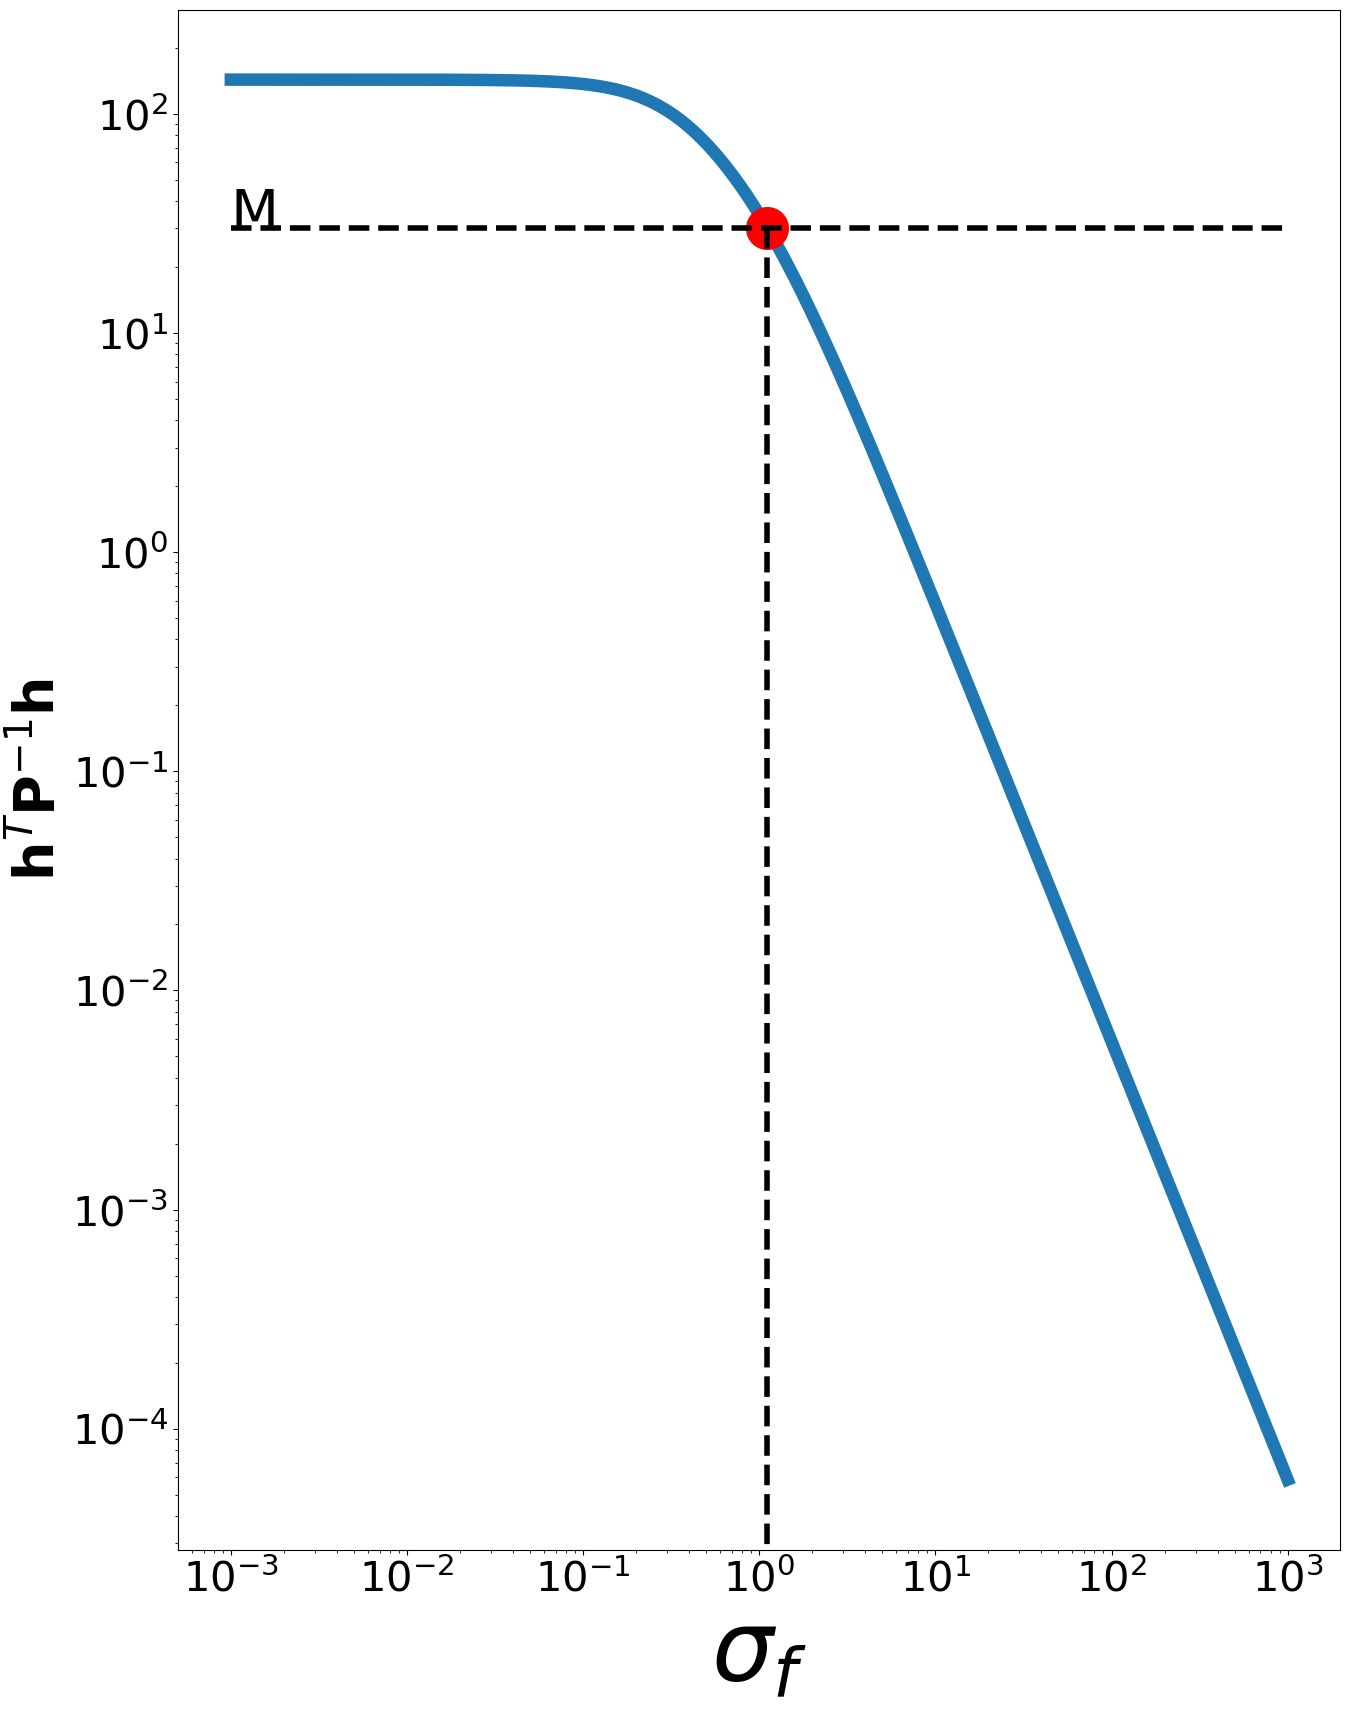

In [53]:
fig = figure(figsize=(15, 20))
rcParams.update({'font.size': 20})
loglog(sigmas,J,linewidth=9)
loglog(sigmas[chi_index],J[chi_index],'ro',markersize=30)
loglog(sigmas,mdata*ones(len(sigmas)), 'k--',linewidth=4)
loglog([sigmas[chi_index], sigmas[chi_index]], [J[chi_index], 0], 'k--',linewidth=4)
text(sigmas[0], mdata, 'M', fontsize=40, color='k')

xlabel(r'$\sigma _f$', fontsize=70)
ylabel(r'$ \mathbf{h}^T\mathbf{P} ^{-1} \mathbf{h}$', fontsize=40)
tick_params(axis='both', labelsize=30)
savefig('chi_3.png')
show()


In [34]:
print(f"\n Optimal L-curve sigma: {optimal_Lcurve_sigma**2:.5f}\n")
print(f"Optimal GCV sigma: {optimal_GCV_sigma**2:.5f}\n")
print(f'optimal_Cf_chi_square = {optimal_chi_square_sigma**2:.5f}\n')


 Optimal L-curve sigma: 1.3370e+00

Optimal GCV sigma: 8.8297e-01

optimal_Cf_chi_square = 1.2305e+00



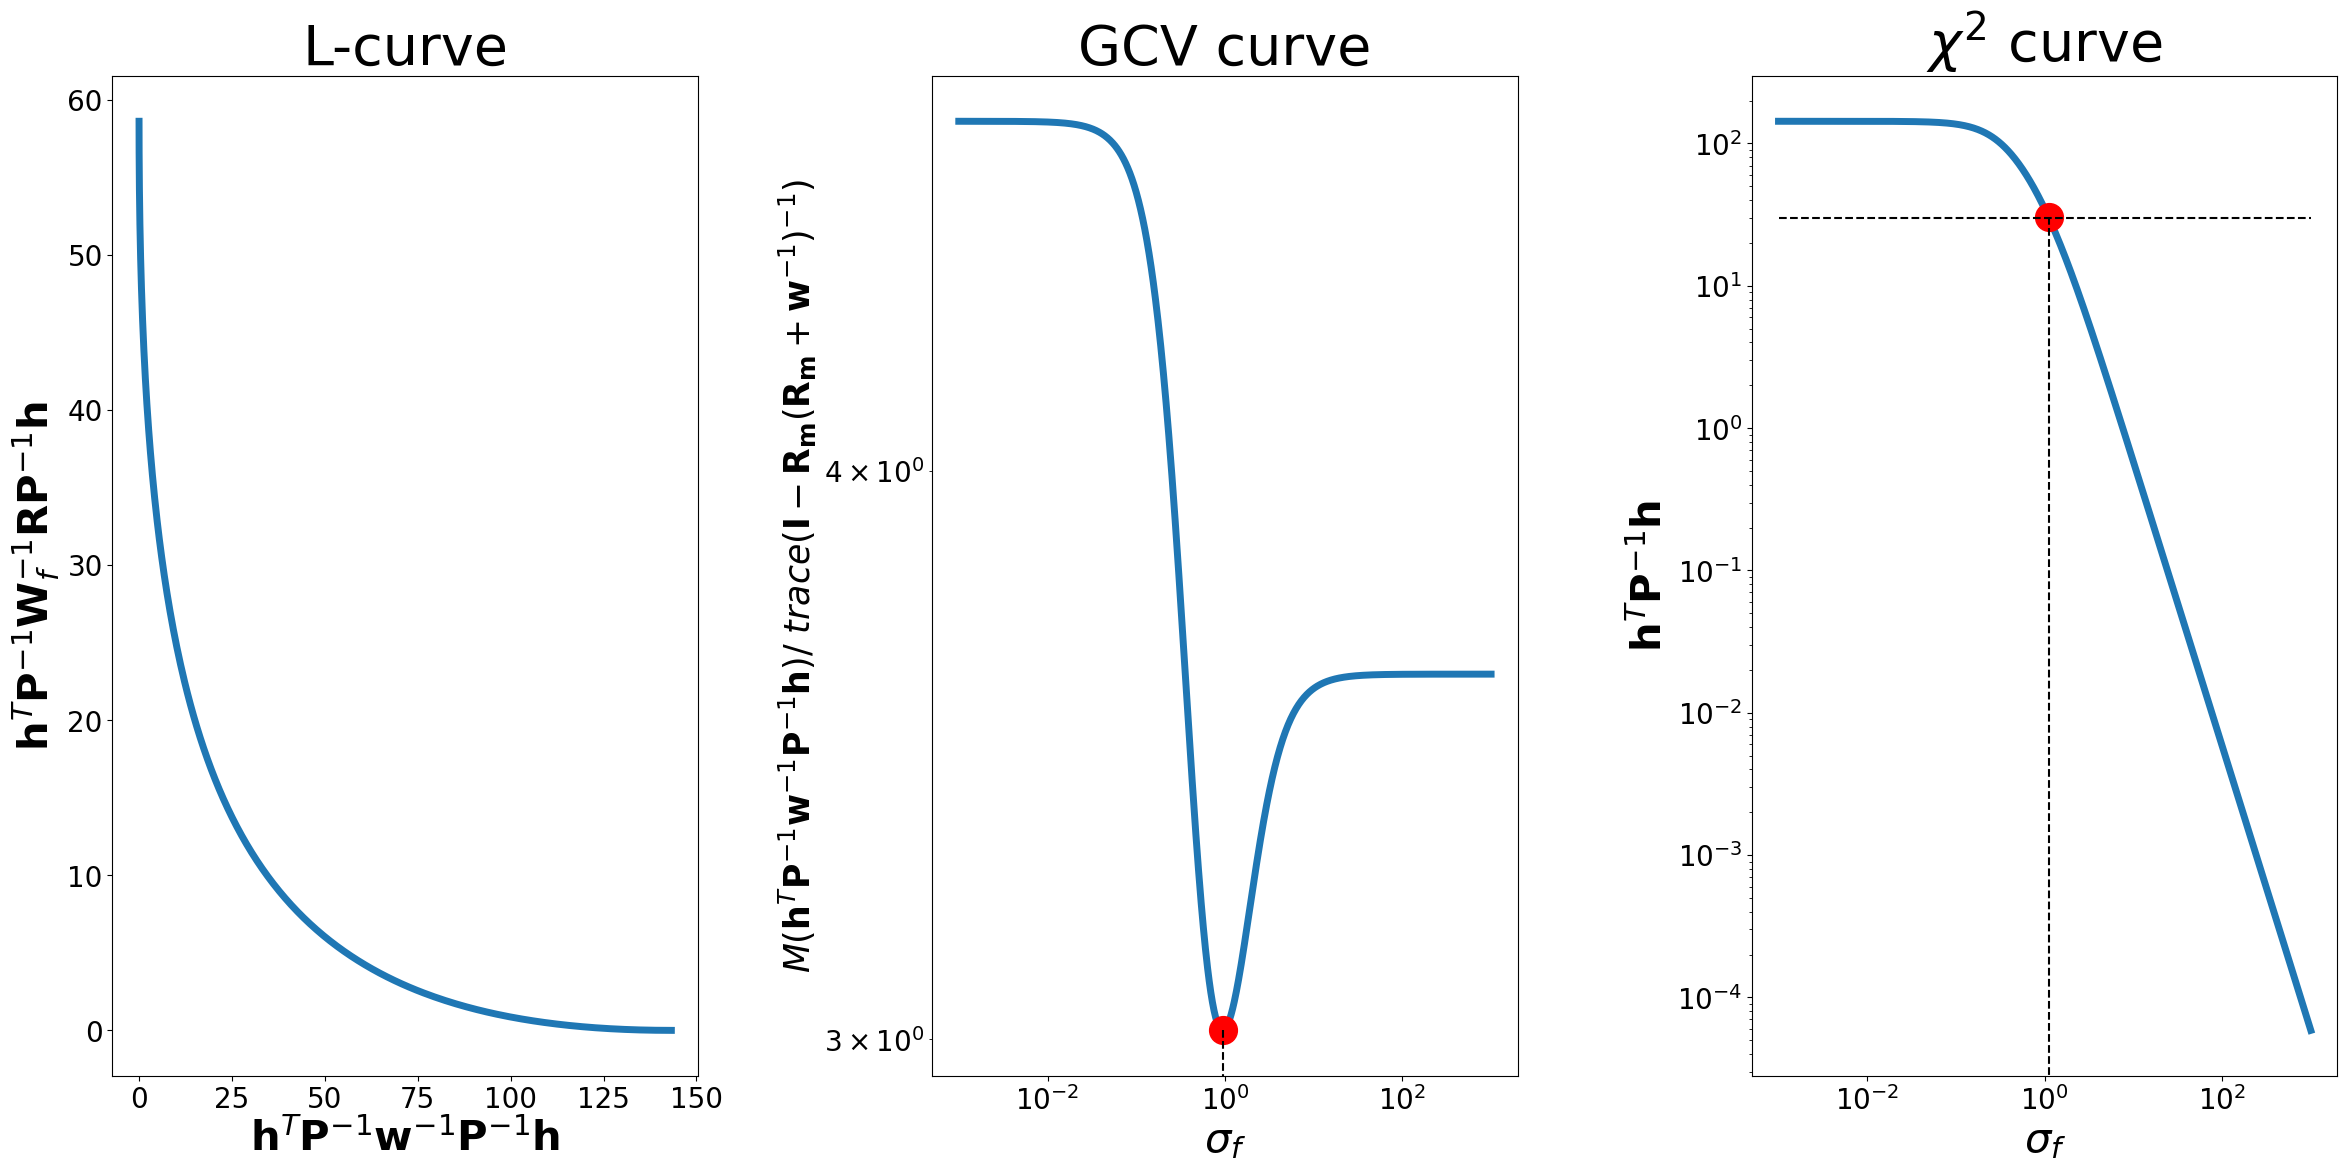

In [35]:
fig = subplots(1, 3, figsize=(25, 20))
# ax = gca()  # Get the current Axes instance
# ax.spines['bottom'].set_position(('data', 0))
subplots_adjust(left=0.11,bottom=0.3,right=1,top=0.8,wspace=0.4,hspace=0.4) 
subplot(1,3,1)
plot(res_norm,reg_norm,linewidth=5)
# plot(res_norm[corner_index[0][0]],reg_norm[corner_index[0][0]],'ro',markersize=20)
title(r'L-curve', fontsize=40)
ylabel(r'$ \mathbf{h}^T\mathbf{P} ^{-1} \mathbf{W}_f ^{-1}\mathbf{R} \mathbf{P} ^{-1} \mathbf{h}$', fontsize=30)
xlabel(r'$ \mathbf{h}^T\mathbf{P}^{-1}\mathbf{w}^{-1}\mathbf{P}^{-1}\mathbf{h}$', fontsize=30)


subplot(1,3,2)
loglog(sigmas,gcv_scores,linewidth=5)
loglog(sigmas[min_index],gcv_scores[min_index],'ro',markersize=20)
loglog([sigmas[min_index], sigmas[min_index]], [gcv_scores[min_index], 0], 'k--')
# ax = gca()  # Get the current Axes instance
# ax.spines['bottom'].set_position(('data', 0))
title(r'GCV curve', fontsize=40)
xlabel(r'$\sigma _f$', fontsize=30)
ylabel(r'$ M(\mathbf{h}^T\mathbf{P} ^{-1}\mathbf{w} ^{-1} \mathbf{P} ^{-1}\mathbf{h}$)/ $trace(\mathbf{I} - \mathbf{R_m}(\mathbf{R_m} + \mathbf{w} ^{-1})^{-1})$', fontsize=25)


subplot(1,3,3)
rcParams.update({'font.size': 20})
loglog(sigmas,J,linewidth=5)
loglog(sigmas[chi_index],J[chi_index],'ro',markersize=20)
loglog(sigmas,mdata*ones(len(sigmas)), 'k--')
loglog([sigmas[chi_index], sigmas[chi_index]], [J[chi_index], 0], 'k--')

title(r'$\chi ^2$ curve', fontsize=40)
xlabel(r'$\sigma _f$', fontsize=30)
ylabel(r'$ \mathbf{h}^T\mathbf{P} ^{-1} \mathbf{h}$', fontsize=30)
# savefig('expt2-reg_params.png')
show()